In [1]:
import pickle
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import nltk.data
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import display

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return pickle.load(handle)

In [3]:
master_dict = load_part('data/tmdb_info.pickle')

In [4]:
with open('data/movie_info.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['movie_id', 'release_date', 'budget', 'revenue',  'genre', 'cast'])
    for movie_id, movie in master_dict.iteritems():
        for genre in movie.genres:
            writer.writerow([movie_id, 
                 movie.release_date, 
                 movie.budget, 
                 movie.revenue, 
                 genre['name'],
                u'|'.join([c['name'] for c in movie.cast]).encode('utf-8').strip()                            
            ])

Create 'flat' data frame with one genre per movie.

In [5]:
df = pd.DataFrame.from_csv('data/movie_info.csv')

In [6]:
df['release_date'] = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].dt.year
df['budget'] = df['budget'].replace(0, np.nan)
df['revenue'] =  df['revenue'].replace(0, np.nan)

In [7]:
df.sample(n = 5)

,release_date,budget,revenue,genre,cast,year
movie_id,,,,,,
225887,2013-09-03,NaN,NaN,Music,Mike Portnoy|Billy Sheehan|Derek Sherinian|Ton...,2013.0
267428,2014-04-25,NaN,NaN,Crime,Trevor Morgan|Elizabeth Rice|Analeigh Tipton|A...,2014.0
340401,2015-07-23,NaN,NaN,Comedy,Otto Waalkes|Tobias Schenke|Martin Goeres|Katy...,2015.0
432005,1966-10-20,NaN,NaN,Documentary,Jimmy Smith|Dizzy Gillespie,1966.0
355343,1993-01-14,NaN,NaN,Thriller,Jayaram Subramaniam|Jagathy Sreekumar|Sindhuja...,1993.0


Budget and revenue have a lot of missing values, we should either not use them or recover more from IMDB

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003B5D4908>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x0000000052657CF8>]], dtype=object)

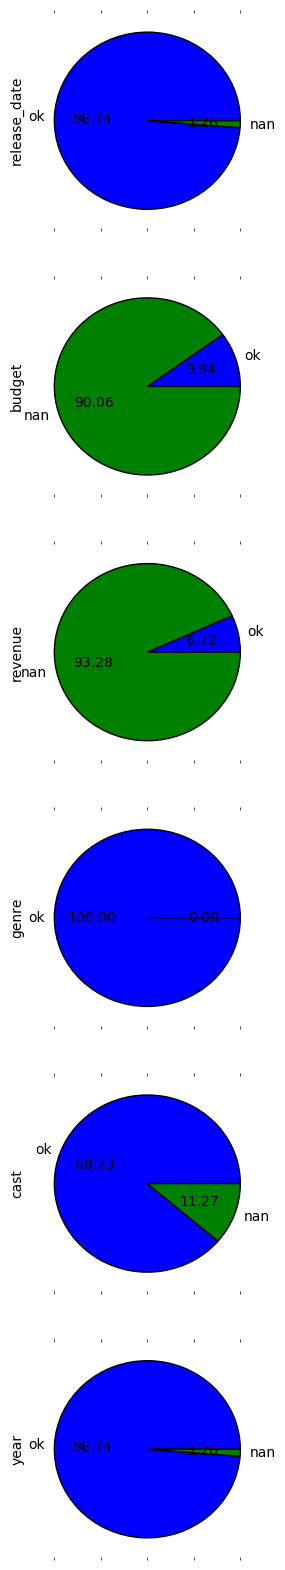

In [15]:
count_df = pd.DataFrame({'ok' : df.count()})
count_df['nan'] = df.shape[0] - count_df['ok']
count_df.transpose().plot.pie(subplots = True, autopct='%.2f', layout = (6, 1), figsize=(3, 20), legend = False)

The genres dlass is quite unbalanced. We should balance the dataset by getting more movies for less frequent genres.

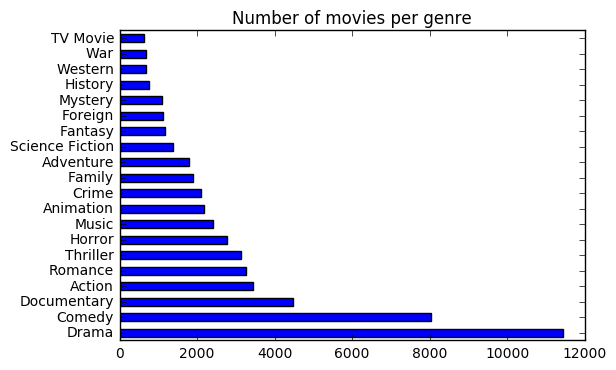

In [17]:
df['genre'].value_counts().plot(kind="barh", title = 'Number of movies per genre')
plt.show()

We should try to balance movies per year as well, especially if posters are different style for old movies.

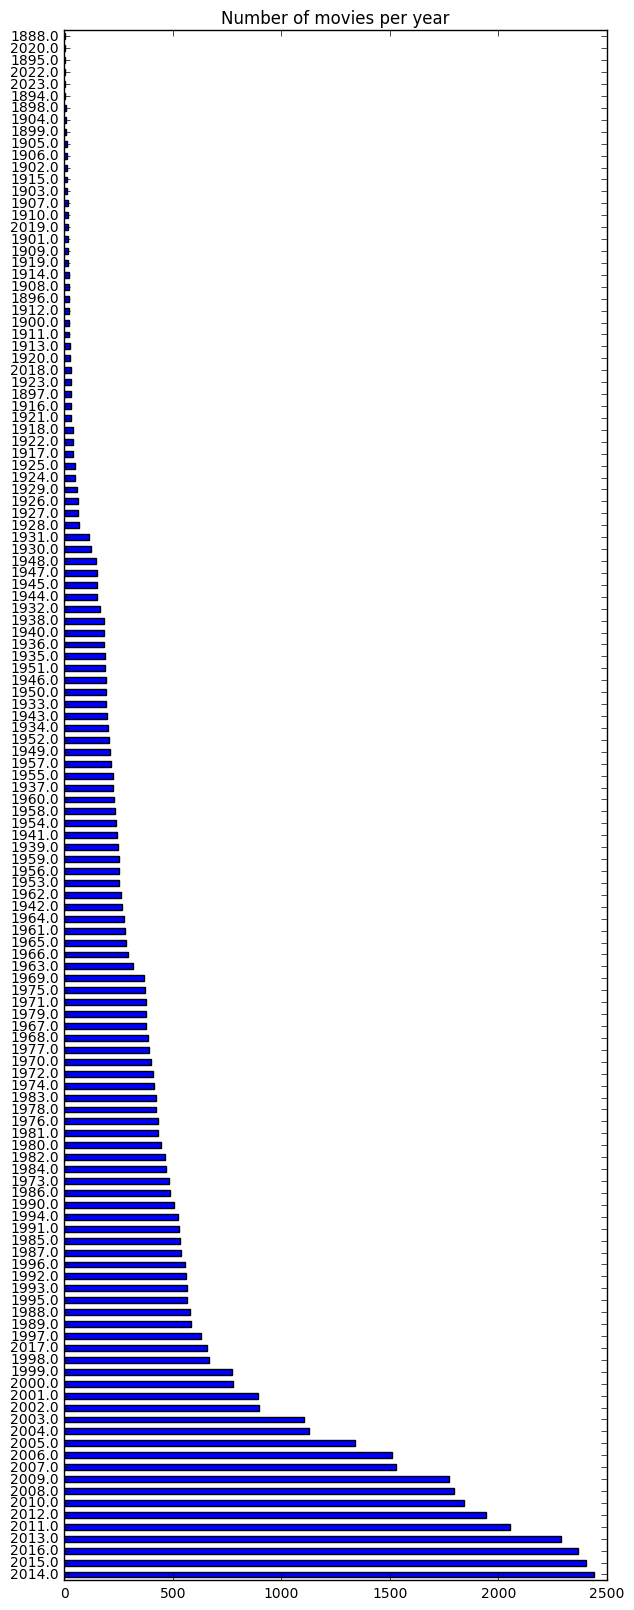

In [19]:
df['year'].value_counts().plot(kind="barh", figsize = (7, 20), title = 'Number of movies per year')
plt.show()

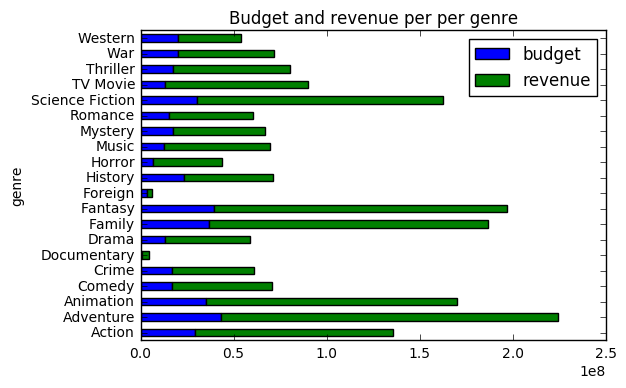

In [11]:
df.groupby(['genre'])['budget', 'revenue'].mean().plot(
    kind = 'barh', stacked = True, title = 'Budget and revenue per per genre')
plt.show()

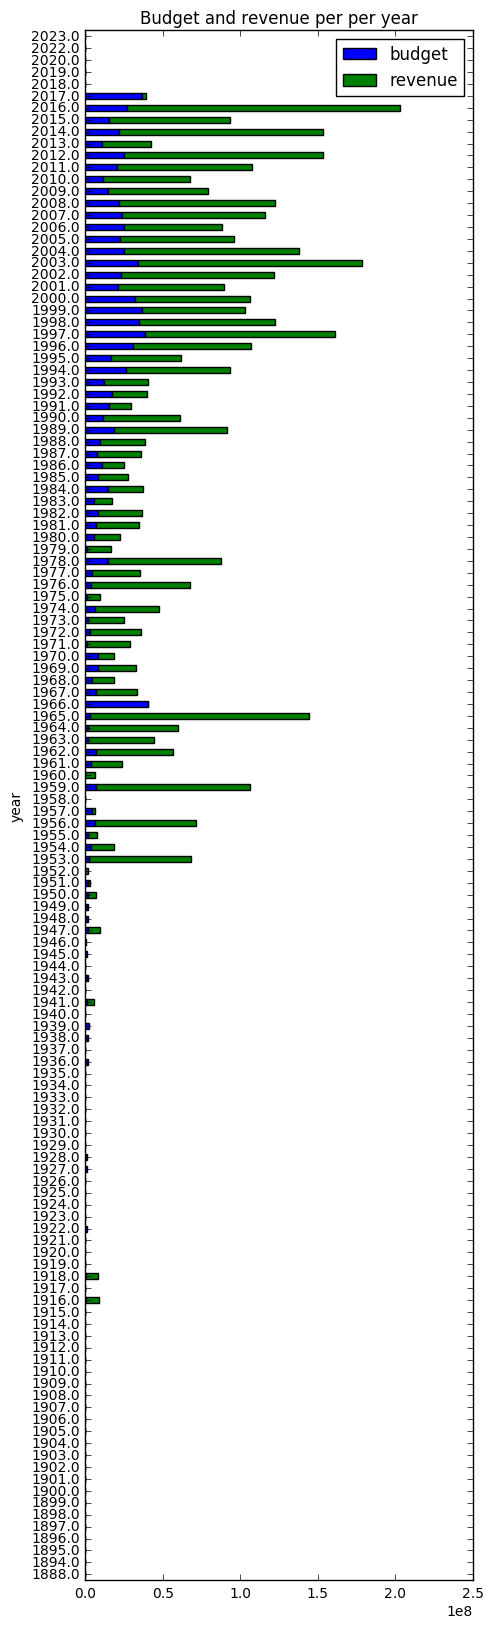

In [12]:
df.groupby(['year'])['budget', 'revenue'].mean().plot(
    kind = 'barh', stacked = True, figsize = (5, 20), title = 'Budget and revenue per per year')
plt.show()

We coud handle cast as tokens but we need to recover cast from IMDB if we'd like to use it in our model.

In [13]:
df_no_na = df.dropna()
vectorizer = CountVectorizer( 
    stop_words = stopwords.words("english"), 
    tokenizer=lambda s: s.split('|'),
    max_df = 0.9, 
    min_df = 5, 
    dtype=np.float32 )
X = vectorizer.fit_transform(df_no_na['cast'].values).toarray()
print 'predictor matrix shape:', X.shape

predictor matrix shape: (2649L, 3290L)


In [14]:
feature_names = np.array(vectorizer.get_feature_names())
feature_names

array([u' frank nagai', u'a.e. matthews', u'aamir khan', ...,
       u'\xe9ric th\xe9obald', u'\xf3lafur darri \xf3lafsson',
       u'\xf3scar jaenada'], 
      dtype='<U27')